In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import pyarrow as pa
from matplotlib.patches import Patch
import pyarrow.dataset as ds
import numpy as np
import yaml
from gelos import config
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

2025-11-26 01:29:30.325 | INFO     | gelos.config:<module>:11 - PROJ_ROOT path is: /app


In [2]:
yaml_config_directory = config.PROJ_ROOT / 'gelos' / 'configs'
# yaml_name = 'terramind_embedding_generation.yaml'
yaml_name = 'prithvi_eo_300m_embedding_generation.yaml'
with open(yaml_config_directory / yaml_name, "r") as f:
    yaml_config = yaml.safe_load(f)
print(yaml.dump(yaml_config))

data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - RED_EDGE_1
      - NIR_BROAD
      - NIR_NARROW
    batch_size: 1
    num_workers: 0
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: vit_cls
    has_cls: true
    model: prithvi_eo_v2_300
    model_args:
      backbone: prithvi_eo_v2_300
      backbone_bands:
      - BLUE
      - GREEN
      - RED
      - RED_EDGE_1
      - NIR_BROAD
      - NIR_NARROW
      backbone_pretrained: true
    output_format: parquet
seed_everything: 0
trainer:
  accelerator: auto
  callbacks: []
  devices: auto
  max_epochs: 0
  num_nodes: 1
  strategy: auto



In [3]:
model_name = yaml_config['model']['init_args']['model']
output_dir = config.INTERIM_DATA_DIR / config.DATA_VERSION / model_name
output_dir.mkdir(exist_ok=True)

data_root = config.RAW_DATA_DIR / config.DATA_VERSION

# add variables to yaml config so it can be passed to classes
yaml_config['data']['init_args']['data_root'] = data_root
yaml_config['model']['init_args']['output_dir'] = output_dir

In [4]:
chip_df = gpd.read_file(data_root / 'cleaned_df.geojson')

In [5]:
embeddings_directories = [item for item in output_dir.iterdir() if item.is_dir()]

In [6]:
directory = embeddings_directories[0]

In [7]:
dataset = ds.dataset(str(directory), format='parquet')
table = dataset.to_table(columns=["embedding"])
emb_list = table.column("embedding")

concatenated = pa.concat_arrays(emb_list.chunks)
values = concatenated.values.to_numpy(zero_copy_only=False)

n_rows = len(concatenated)
embeddings = values.reshape(n_rows, -1)
print(embeddings.shape)


(273, 1024)


In [8]:
len(emb_list[0][0])

TypeError: object of type 'pyarrow.lib.DoubleScalar' has no len()

In [ ]:
values.shape

(11736,)

In [9]:
def extract_embeddings_from_directory(directory: Path | str) -> np.array:
    # extract embeddings in numpy format from geoparquet
    dataset = ds.dataset(str(directory), format='parquet')
    table = dataset.to_table(columns=["embedding"])
    emb_list = table.column("embedding")

    concatenated = pa.concat_arrays(emb_list.chunks)
    values = concatenated.values.to_numpy(zero_copy_only=False)

    n_rows = len(concatenated)
    embeddings = values.reshape(n_rows, -1)
    print(embeddings.shape)

    return embeddings

def tsne_from_embeddings(embeddings: np.array) -> np.array:
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)
    embeddings_tsne = tsne.fit_transform(embeddings)
    return embeddings_tsne

def plot_from_tsne(
        embeddings_tsne: np.array,
        chip_df: gpd.GeoDataFrame,
        model_name: str,
        legend_patches = list[Patch],
        axis_lim: int = 90,
        output_dir: str | Path = None
        ) -> None:
    """
    plot a tSNE transform of embeddings colored according to land cover
    """
    colors = chip_df.head(embeddings_tsne.shape[0])['color']
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_tsne[:, 1], -embeddings_tsne[:, 0], c=colors, s=2)
    plt.title(f"t-SNE Visualization of EO-FM-Bench Embeddings for {model_name}", fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.xlim([-axis_lim, axis_lim])
    plt.ylim([-axis_lim, axis_lim])
    plt.legend(handles=legend_patches, loc="upper left", fontsize=10, framealpha=0.9)

    if output_dir:
        plt.savefig(output_dir / "tsne.png", dpi=600, bbox_inches="tight")
    else:
        plt.show()

In [10]:
land_cover_cmap = {
    "1": "#419bdf",  # Water
    "2": "#397d49",  # Trees
    "5": "#e49635",  # Crops
    "7": "#c4281b",  # Built Area
    "8": "#a59b8f",  # Bare Ground
    "11": "#e3e2c3"   # Rangeland
}
legend_patches = [
    Patch(color=color, label=name)
    for name, color in [
        ("Water", "#419bdf"),
        ("Trees", "#397d49"),
        ("Crops", "#e49635"),
        ("Built Area", "#c4281b"),
        ("Bare Ground", "#a59b8f"),
        ("Rangeland", "#e3e2c3"),
    ]
]
def get_color_from_status(land_cover: float):
    land_cover_string = str(land_cover).split('.')[0]
    hex_color = land_cover_cmap.get(land_cover_string, '#000000')
    return hex_color
chip_df['color']=chip_df['land_cover'].apply(lambda x: get_color_from_status(x))



(273, 1024)


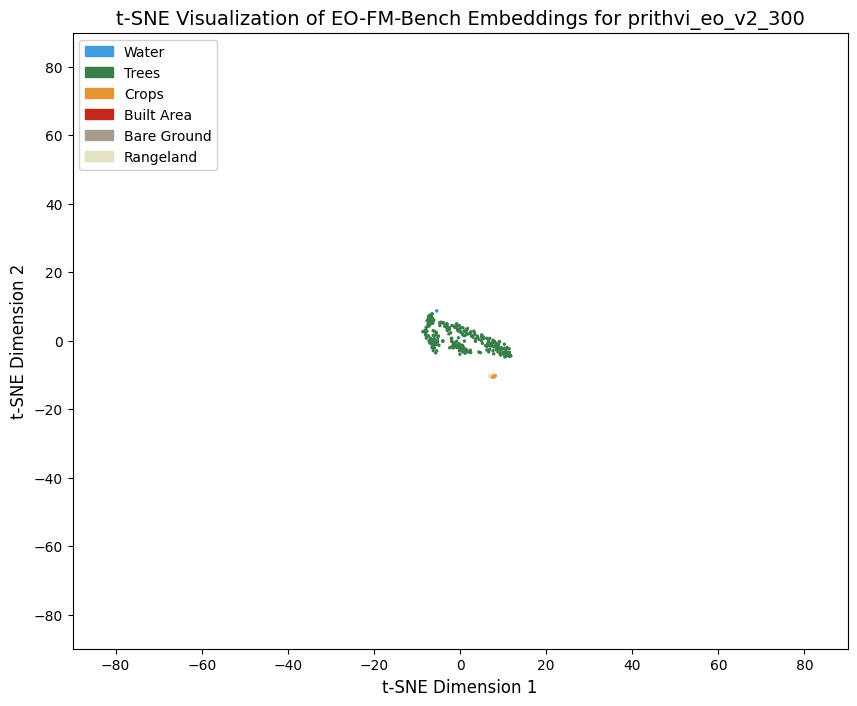

In [11]:
for embeddings_directory in embeddings_directories:
    embeddings = extract_embeddings_from_directory(embeddings_directory)
    embeddings_tsne = tsne_from_embeddings(embeddings)
    plot_from_tsne(embeddings_tsne, chip_df, model_name, legend_patches)